In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
# basic imports
import random
import time
import pickle
import xlrd
import scanpy as sc
from glob import glob
import pandas as pd
from copy import deepcopy
from bs4 import BeautifulSoup
from scipy.interpolate import make_interp_spline
from scipy.stats import pearsonr, zscore, rankdata, fisher_exact, ttest_ind, linregress
import os, sys
from multiprocessing import Pool
import scipy
from copy import deepcopy
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import pyplot
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

In [3]:
clus_binary_df = pd.read_csv('./Data/peak_order.csv', index_col=0)
gsb_df = pd.read_csv('./Data/peak_order.gsb.csv', index_col=0)

In [4]:
sc_bookmarked_peak_file = './Data/sc_bookmarked.peaks.bed'
unbookmarked_peak_file = './Data/unbookmarked.peaks.bed'

sc_bookmarked_peaks = [x.strip().split('\t')[3] for x in open(sc_bookmarked_peak_file).readlines()]
unbookmarked_peaks = [x.strip().split('\t')[3] for x in open(unbookmarked_peak_file).readlines()]

In [5]:
nb_sc_bookmarked = len(sc_bookmarked_peaks)
nb_unbookmarked = len(unbookmarked_peaks)

In [6]:
peak_anno_df = pd.read_csv('./Data/top_filtered_peak.anno.txt', index_col=0, sep='\t')

In [7]:
nfya_site_file = './Data/idr_NFYA_p12_igg_bam_peaks.bed'

In [8]:
nb_nfya = int(os.popen('wc -l %s' % nfya_site_file).read().strip().split(' ')[0])

In [9]:
nfya_anno_df = pd.read_csv('./Data/NFYA_anno.peaks.txt', index_col=0, sep='\t')

In [10]:
nfya_prefix_genes_dict = {}

In [11]:
nfya_bookmark_peaks = os.popen('bedtools intersect -a %s -b %s -wa | sort -u | awk \'{print $4}\' ' % (nfya_site_file, sc_bookmarked_peak_file)).read().strip().split('\n')
nfya_bookmark_genes = list(set(nfya_anno_df.loc[nfya_bookmark_peaks,'Gene Name']))
nfya_bookmark_genes.remove(np.nan)

nfya_prefix_genes_dict['NFYA_bookmark'] = nfya_bookmark_genes

In [12]:
bookmark_no_nfya_peaks = os.popen('bedtools intersect -a %s -b %s -v | sort -u | awk \'{print $4}\' ' % (sc_bookmarked_peak_file, nfya_site_file)).read().strip().split('\n')
bookmark_no_nfya_genes = list(set(peak_anno_df.loc[bookmark_no_nfya_peaks,'Gene Name']))
bookmark_no_nfya_genes.remove(np.nan)

nfya_prefix_genes_dict['bookmark_no_nfya'] = bookmark_no_nfya_genes

In [13]:
nfya_unbookmark_peaks = os.popen('bedtools intersect -a %s -b %s -v | sort -u | awk \'{print $4}\' ' % (nfya_site_file, sc_bookmarked_peak_file)).read().strip().split('\n')
nfya_unbookmark_genes = list(set(nfya_anno_df.loc[nfya_unbookmark_peaks,'Gene Name']))
nfya_unbookmark_genes.remove(np.nan)

nfya_prefix_genes_dict['NFYA_unbookmark'] = nfya_unbookmark_genes

In [63]:
nfya_prefix_genes_dict2 = {}

nfya_targets = list(set(nfya_anno_df['Gene Name']))
nfya_targets.remove(np.nan)
nfya_prefix_genes_dict2['nfya_targets'] = nfya_targets

# Fig 4A

In [21]:
def denovo_resolve(inFile):
    soup = BeautifulSoup(open(inFile,'r').read(),'html.parser')
    rawLines_ls = list(soup.find_all('td'))
    lines = [str(x).split('>')[1].split('<')[0].strip() for x in rawLines_ls]
    ## remove all blank value
    while '' in lines:
        lines.remove('')
    title_ls = ['Rank','-logP','logP_pvalue','Targets%','Background%','STD','Motif']
    nb_line = len(title_ls)
    inDic = {}
    for idx in range(nb_line):
        inDic[title_ls[idx]] = lines[9+idx::7]
    inDf = pd.DataFrame(inDic)
    inDf = inDf.reindex(columns=title_ls)
    inDf.loc[inDf['-logP']=='1e0','-logP'] = inDf.loc[inDf['-logP']=='1e0','-logP'].apply(lambda x:'1e-0')
    inDf['-logP'] = inDf['-logP'].apply(lambda x:int(x[3:]))
    # inDf['Motif'] = inDf['Motif'].apply(lambda x:nameSplit(x))
    inDf['Motif'] = inDf['Motif'].apply(lambda x:x.split('/')[0])
    
    return inDf

In [22]:
homer_file = './Data/homerResults.html'
homer_result_df = denovo_resolve(homer_file).iloc[:10]

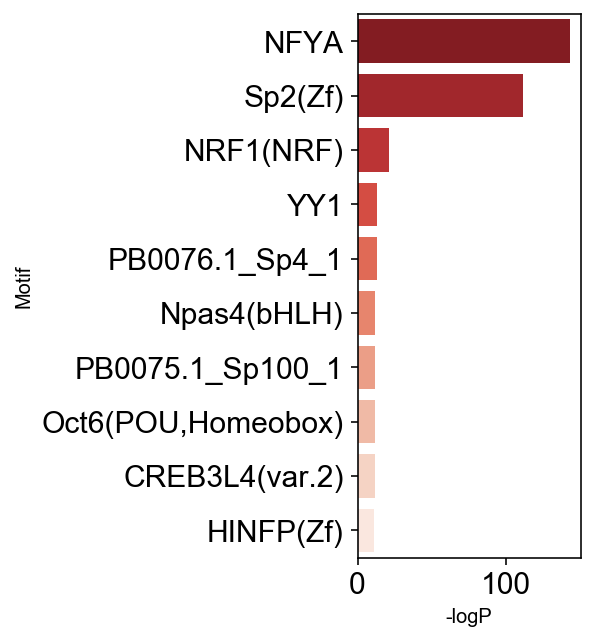

In [23]:
ax21 = plt.figure(figsize=(2,5)).add_subplot(111)
sns.barplot(x=homer_result_df['-logP'], y=homer_result_df['Motif'], 
            orient='h', palette="Reds_r", ax=ax21)
for tick in ax21.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax21.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)

# Fig 4C

In [87]:
df = pd.read_csv('./Data/nfya_binding_peaks_heatmap.txt', sep='\t', index_col=0).values

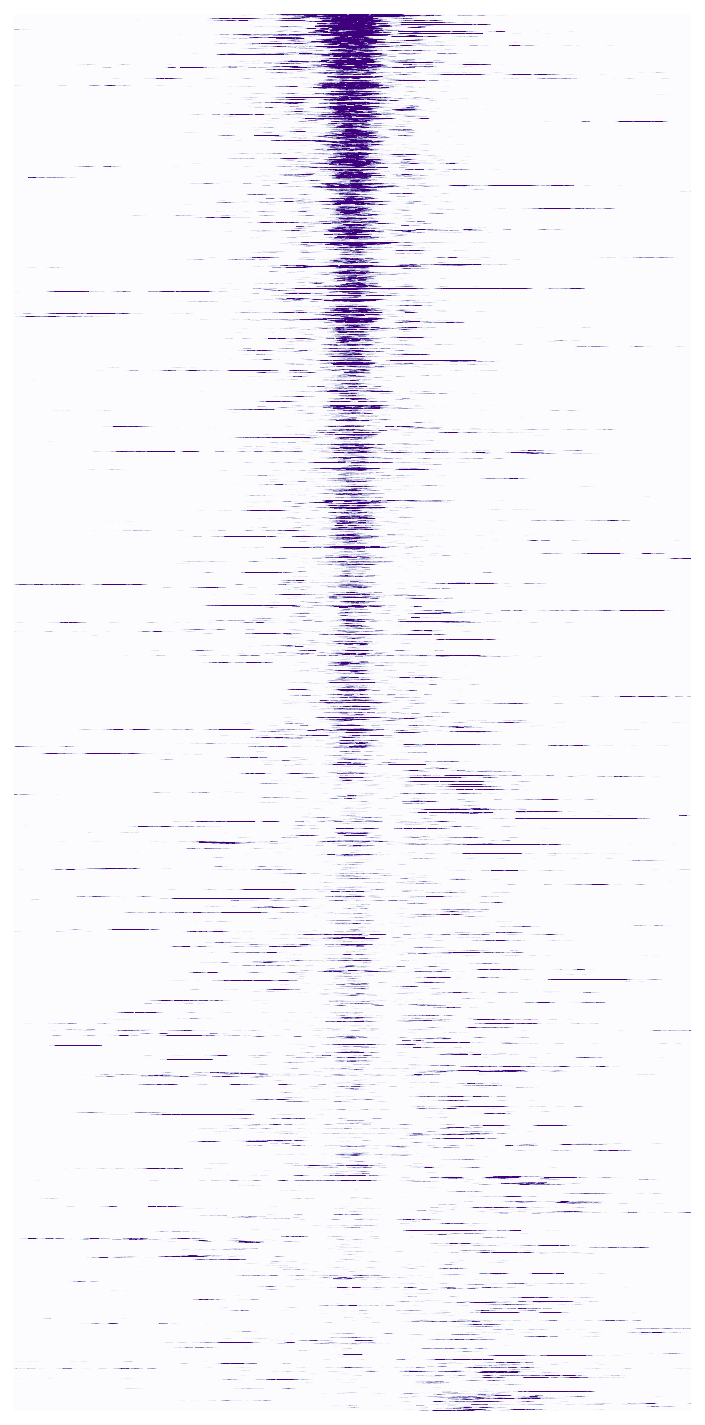

In [88]:
plt.figure(figsize=(5,10))
sns.heatmap(df, cmap='Purples', vmax=50, vmin=10, xticklabels=False, yticklabels=False, cbar=False)
plt.tight_layout()

# Fig 4D

In [24]:
bulk_bookmark_peak_file = './Data/lo2_bookmark.peaks.bed'
bulk_shared_peak_file = './Data/hepG2_huh7_lo2_overlapbookmark.peaks.bed'
bulk_unique_peak_file = './Data/lo2_uniqbookmark.peaks.bed'

In [25]:
bulk_bookmarked_not_sc_peaks = os.popen('bedtools intersect -a %s -b %s -v | sort -u | awk \'{print $4}\' ' % (bulk_bookmark_peak_file, sc_bookmarked_peak_file)).read().strip().split('\n')

In [26]:
peak_class_dict2 = {}

peak_class_dict2['sc_bookmarked'] = sc_bookmarked_peaks
peak_class_dict2['unbookmarked'] = unbookmarked_peaks
peak_class_dict2['bulk_bookmarked_unique'] = bulk_bookmarked_not_sc_peaks

In [37]:
prefix_peak_file_dict = {
    'sc_bookmarked':'./Data/sc_bookmarked.peaks.bed', 'unbookmarked':unbookmarked_peak_file, 
    'bulk_bookmarked_unique':'./Data/bulk_bookmark.unique_sc_bookmark.peaks.bed'
}

In [38]:
ratio_ls = []
for prefix in peak_class_dict2.keys():
    nb_peak = len(peak_class_dict2[prefix])
    prefix_file = prefix_peak_file_dict[prefix]
    nb_overlap = int(os.popen('bedtools intersect -a %s -b %s -wa | sort -u | wc -l' % (prefix_file, nfya_site_file)).read().strip().split(' ')[0])
    ratio = nb_overlap / nb_peak
    print(prefix, ratio)
    ratio_ls.append(ratio)

sc_bookmarked 0.6056024899955536
unbookmarked 0.1603687284497924
bulk_bookmarked_unique 0.06293566520924422


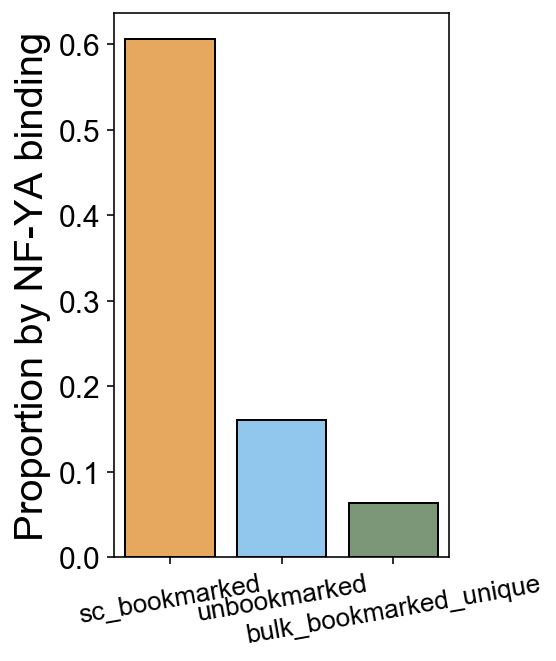

In [39]:
fig = plt.figure(figsize=(3,5))
ax21 = plt.subplot(111)
sns.barplot(x=list(peak_class_dict2.keys()), y=ratio_ls, ax=ax21, 
            edgecolor='black', palette=['#fdaa48','#82cafc','#789b73'])

_ = plt.xticks(rotation=10)
for tick in ax21.xaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in ax21.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
# _ = ax21.set_xlabel('')
_ = ax21.set_ylabel('Proportion by NF-YA binding', fontsize=20)

# Fig 4E

In [78]:
def embedded_numbers(s):
    re_digits = re.compile(r'(\d+)')
    pieces = re_digits.split(s)
    pieces[1::2] = map(int, pieces[1::2])
    return pieces
def sort_strings_with_embedded_numbers(alist):
    return sorted(alist, key=embedded_numbers)

def prefixTrans(prefix):
    if prefix == '40min' or prefix == '80min':
        wave = 'fisrtWave'
    elif prefix == '105min' or prefix == '165min':
        wave = 'nextWave'
    elif prefix == '300min' or prefix == 'Async':
        wave = 'lastWave'
    elif prefix == 'liver':
        wave = 'liverSpe'
    return wave
wave_ls = ['fisrtWave','nextWave','lastWave','liverSpe']
time_ls = ['40min','80min','105min','165min','300min','Async','liverSpe']
sciFiles = sort_strings_with_embedded_numbers(glob('{0}/transcripts_Supplemental_Tables/*_gene_S*.txt'.format('./Data')))
sci_gene_dict = {}
for inFile in sciFiles:
    prefix = inFile.split('/')[-1].split('_')[0]
    sciGene_ls = list(set(pd.read_table(inFile,index_col=0).index))
    sci_gene_dict[prefix] = sciGene_ls
sci_gene_dict2 = {}
for inFile in sciFiles:
    prefix = inFile.split('/')[-1].split('_')[0]
    sciGene_ls = list(set(pd.read_table(inFile,index_col=0).index))
    
    if prefixTrans(prefix) not in sci_gene_dict2:
        sci_gene_dict2[prefixTrans(prefix)] = sciGene_ls
    else:
        sci_gene_dict2[prefixTrans(prefix)].extend(sciGene_ls)

In [80]:
nfya_coverage_df = pd.read_csv('./Data/nfya_counts.csv', index_col=0)
igg_coverage_df = pd.read_csv('./Data/igg_counts.csv', index_col=0)

In [81]:
all_genes = nfya_coverage_df.index.tolist()

In [82]:
sci_nfya_coverage_counts = []
gene_count = []

for sci in ['fisrtWave', 'nextWave', 'lastWave']:
    sci_genes = sci_gene_dict2[sci]
    sci_genes = list(set(sci_genes).intersection(set(all_genes)))
    gene_count.append(len(sci_genes))
    
    sci_nfya_coverage_counts.append(nfya_coverage_df.loc[sci_genes].sum().tolist())

In [84]:
sci_nfya_coverage_count_df = pd.DataFrame(sci_nfya_coverage_counts).T
sci_nfya_coverage_count_df.columns = ['fisrtWave', 'nextWave', 'lastWave']

In [85]:
fisrt_count = sci_nfya_coverage_count_df['fisrtWave'] / gene_count[0]
second_count = sci_nfya_coverage_count_df['nextWave'] / gene_count[1]
third_count = sci_nfya_coverage_count_df['lastWave'] / gene_count[2]

igg_count = igg_coverage_df.mean()

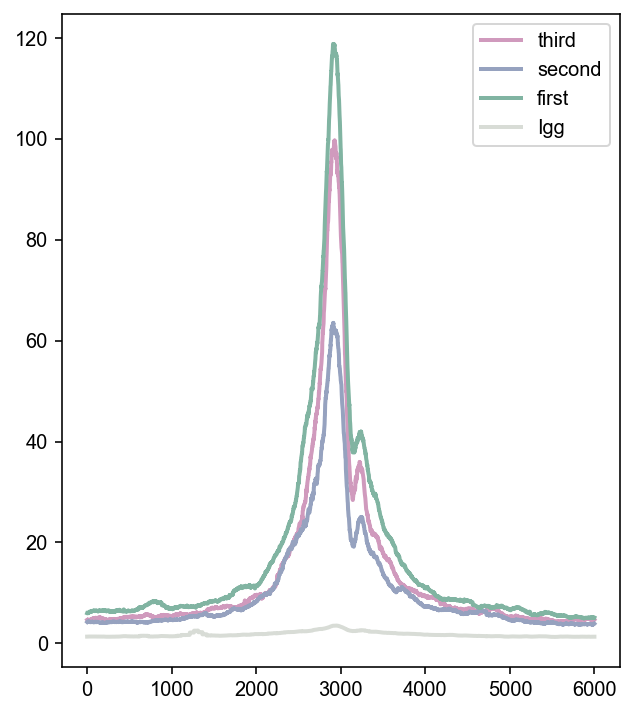

In [86]:
fig = plt.figure(figsize=(5,6))
ax21 = plt.subplot(111)

ax21.plot(third_count.values, label='third', color='#d09abd', linewidth=2)
ax21.plot(second_count.values, label='second', color='#96a2bf', linewidth=2)
ax21.plot(fisrt_count.values, label='first', color='#81b4a2', linewidth=2)
ax21.plot(igg_count.values, label='Igg', color='#d8dcd6', linewidth=2)
ax21.legend(loc='best')